<a href="https://colab.research.google.com/github/ghostwalkin/e2e-Resnet-based-classifier/blob/main/img_class.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#dependencies

In [1]:
!pip install -q lightning wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.4/40.4 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 24.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 927.3/927.3 kB 52.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 819.3/819.3 kB 43.9 MB/s eta 0:00:00


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim
import lightning as L
from torchvision.transforms import v2
from torchvision.models import resnet50, ResNet50_Weights

import pandas as pd
import numpy as np

from PIL import Image
import matplotlib.pyplot as plt

import cv2

In [3]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"dparijat2","key":"97680f5ec7b6cf127f4db60909f3b298"}'}

#data

In [4]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [7]:
!kaggle datasets download alessiocorrado99/animals10

Dataset URL: https://www.kaggle.com/datasets/alessiocorrado99/animals10
License(s): GPL-2.0
 97% 570M/586M [00:02<00:00, 246MB/s]
100% 586M/586M [00:02<00:00, 221MB/s]


In [8]:
!unzip ./animals10.zip
!rm ./animals10.zip

Streaming output truncated to the last 5000 lines.
  inflating: raw-img/ragno/OIP-MVQChNQpHiMZEVMPehrvoAHaE6.jpeg  
  inflating: raw-img/ragno/OIP-MVdIFDAFpNyK_XCpwkDIWgHaFj.jpeg  
  inflating: raw-img/ragno/OIP-MYY_8k5AHqMJwTCNXfH6rwHaFj.jpeg  
  inflating: raw-img/ragno/OIP-MZEVXuoMsATG8u_UuTQ6hAHaE8.jpeg  
  inflating: raw-img/ragno/OIP-MZg0tznDRE95AMfyuutuYAHaE6.jpeg  
  inflating: raw-img/ragno/OIP-M_r9DkR2X5gP0P5-z8wPYQHaE7.jpeg  
  inflating: raw-img/ragno/OIP-M_xDUSzjlF3-w9XHCm93cgHaFF.jpeg  
  inflating: raw-img/ragno/OIP-MbI4-bMyutRX3X382IAVcQAAAA.jpeg  
  inflating: raw-img/ragno/OIP-MbMksZdD7gomsC9fd6cpKgHaHJ.jpeg  
  inflating: raw-img/ragno/OIP-Md4AMcvjaHcivJqeW06wEwHaFW.jpeg  
  inflating: raw-img/ragno/OIP-MgCgailkT5XkO1XczzQCngHaLK.jpeg  
  inflating: raw-img/ragno/OIP-MgrKq05YHGXsgj1AmYIyJQHaE8.jpeg  
  inflating: raw-img/ragno/OIP-MhRGx7d8nbnHBuqrsO00EQHaFo.jpeg  
  inflating: raw-img/ragno/OIP-MiVgMXcKGQdog2KGe7i0YQHaHh.jpeg  
  inflating: raw-img/ragno/OIP-Mis0lJf3

In [10]:
from translate import translate
 #for the english name of the classes
translate["ragno"]="spider"

In [8]:
translate

{'cane': 'dog',
 'cavallo': 'horse',
 'elefante': 'elephant',
 'farfalla': 'butterfly',
 'gallina': 'chicken',
 'gatto': 'cat',
 'mucca': 'cow',
 'pecora': 'sheep',
 'scoiattolo': 'squirrel',
 'dog': 'cane',
 'elephant': 'elefante',
 'butterfly': 'farfalla',
 'chicken': 'gallina',
 'cat': 'gatto',
 'cow': 'mucca',
 'spider': 'ragno',
 'squirrel': 'scoiattolo',
 'ragno': 'spider'}

#data preparation

making an usable label dataframe suitable for training

In [11]:
import os
import pandas as pd

#creating a pandas dataframe with img path and class names
img_dir="./raw-img"
image_path=[]
label=[]
for cls in os.listdir(img_dir):
  for img in os.listdir(os.path.join(img_dir,cls)):
    image_path.append(os.path.join(img_dir,cls,img))
    label.append(cls)

df = pd.DataFrame(list(zip(image_path, label)),
               columns =['image_path', 'label'])


In [12]:
df.head()

image_path    label
0  ./raw-img/cavallo/OIP-Lt4KXiB34Ne6wzxww7Z4VQHa...  cavallo
1  ./raw-img/cavallo/OIP-lpCLUlu-xDFxjr-RRix-9AHa...  cavallo
2  ./raw-img/cavallo/OIP-lQTcA7J-p3hkBQuqJJGGIwHa...  cavallo
3  ./raw-img/cavallo/OIP-UyBt99cG7gPsGTdw5FgBRQHa...  cavallo
4  ./raw-img/cavallo/OIP-iNiJSexpflieBf8uOCTYHwHa...  cavallo

In [13]:
df["label"]=df["label"].replace(translate)

In [14]:
df.head()

image_path  label
0  ./raw-img/cavallo/OIP-Lt4KXiB34Ne6wzxww7Z4VQHa...  horse
1  ./raw-img/cavallo/OIP-lpCLUlu-xDFxjr-RRix-9AHa...  horse
2  ./raw-img/cavallo/OIP-lQTcA7J-p3hkBQuqJJGGIwHa...  horse
3  ./raw-img/cavallo/OIP-UyBt99cG7gPsGTdw5FgBRQHa...  horse
4  ./raw-img/cavallo/OIP-iNiJSexpflieBf8uOCTYHwHa...  horse

In [15]:
from sklearn.preprocessing import LabelEncoder
le=LabelEncoder()

df["label"]=le.fit_transform(df["label"])
df.head()

image_path  label
0  ./raw-img/cavallo/OIP-Lt4KXiB34Ne6wzxww7Z4VQHa...      6
1  ./raw-img/cavallo/OIP-lpCLUlu-xDFxjr-RRix-9AHa...      6
2  ./raw-img/cavallo/OIP-lQTcA7J-p3hkBQuqJJGGIwHa...      6
3  ./raw-img/cavallo/OIP-UyBt99cG7gPsGTdw5FgBRQHa...      6
4  ./raw-img/cavallo/OIP-iNiJSexpflieBf8uOCTYHwHa...      6

#data preprocessing

with pytorch dataset and dataloader functions preparing the training and test data

In [17]:
class custom_data(Dataset):
  def __init__(self,img_dir,annotation_file,transforms=None,target_transforms=None):
    self.img_dir=img_dir
    self.annotations=annotation_file
    self.transforms=transforms
    self.target_transforms=target_transforms

  def __len__(self):
    return len(self.annotations)

  def __getitem__(self,index):
    img_path=self.annotations.iloc[index,0]
    image=Image.open(img_path)
    label=self.annotations.iloc[index,1]
    if self.transforms:
      image=self.transforms(image)
    if self.target_transforms:
      label=self.target_transforms(label)
    return image,label


transforms = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.uint8, scale=True),
    v2.Resize(size=(224, 224), antialias=True),
    v2.ToDtype(torch.float32, scale=True),
    v2.Lambda(lambda image: image[:3, :, :]),# Normalize expects float input
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
from sklearn.model_selection import train_test_split
train_df,test_val_df=train_test_split(df,test_size=0.3,random_state=42,shuffle=True)
val_df,test_df=train_test_split(test_val_df,test_size=0.25,random_state=42,shuffle=True)
print(len(train_df),len(test_df),len(val_df))

train_data=custom_data(img_dir,annotation_file=train_df,transforms=transforms)
val_data=custom_data(img_dir,annotation_file=val_df,transforms=transforms)
test_data=custom_data(img_dir,annotation_file=test_df,transforms=transforms)
#train and val_loader
train_loader=DataLoader(train_data,batch_size=32,shuffle=True,)
val_loader=DataLoader(val_data,batch_size=32,shuffle=False)
test_loader=DataLoader(test_data,batch_size=32,shuffle=False)

18325 1964 5890


#model

In [18]:
num_classes=len(df["label"].unique())

In [20]:
class resnet_transfer(L.LightningModule):
  def __init__(self):
    super().__init__()

    backbone=resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)
    num_filterss=backbone.fc.in_features
    layers=list(backbone.children())[:-1]
    self.feature_extractor=nn.Sequential(*layers)
    self.classifier=nn.Linear(num_filterss,num_classes)

  def forward(self,x):
    with torch.no_grad():
      x=self.feature_extractor(x)
    x=torch.flatten(x,1)
    x=self.classifier(x)
    return x

  def training_step(self,batch,batch_idx):
    x,y=batch
    y_pred=self(x)
    loss=F.cross_entropy(y_pred,y)
    self.log("train_loss",loss)
    return loss

  def configure_optimizers(self):
    optimizer=optim.Adam(self.parameters(),lr=0.001)
    return optimizer

  def validation_step(self,batch,batch_idx):
    x,y=batch
    y_pred=self(x)
    loss=F.cross_entropy(y_pred,y)
    self.log("val_loss",loss)
    return loss


#training

In [19]:
#import wandb
#wandb.login()
#from lightning.pytorch.loggers import WandbLogger
#wandb_logger = WandbLogger(project='classification-logger')

# add your batch size to the wandb config
#wandb_logger.experiment.config["batch_size"] = 32

In [21]:
from lightning.pytorch.callbacks.early_stopping import EarlyStopping

model=resnet_transfer()
trainer=L.Trainer(max_epochs=10,callbacks=[EarlyStopping(monitor="val_loss",mode="min",patience=3)],enable_model_summary=True,inference_mode=True)
trainer.fit(model,train_loader,val_loader)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 151MB/s]
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name              | Type       | Params | Mode 
---------------------------------------------------------
0 | feature_extractor | Sequential | 23.5 M | train
1 | classifier        | Linear     | 20.5 K | train
---------------------------------------------------------
23.5 M    Trainable params

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=10` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


In [22]:
trainer.save_checkpoint("model.ckpt")

#test

In [37]:
model=resnet_transfer.load_from_checkpoint("model.ckpt")
model.eval()

resnet_transfer(
  (feature_extractor): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
        

In [38]:
foo=Image.open(test_df.iloc[0,0])
foo=transforms(foo)
foo=foo.unsqueeze(0)
bar=model(foo)
print(bar)

tensor([[-1.1976, -7.3819, -4.9848, -6.6274, -8.2430, -6.7873, -5.5184, -5.2137,
          0.7111, -7.0139]], grad_fn=<AddmmBackward0>)


In [39]:
bar=torch.argmax(bar,1)
print(bar)

tensor([8])


In [45]:
l=torch.tensor([test_df.iloc[0,1]])
print(le.inverse_transform(l))

['spider']


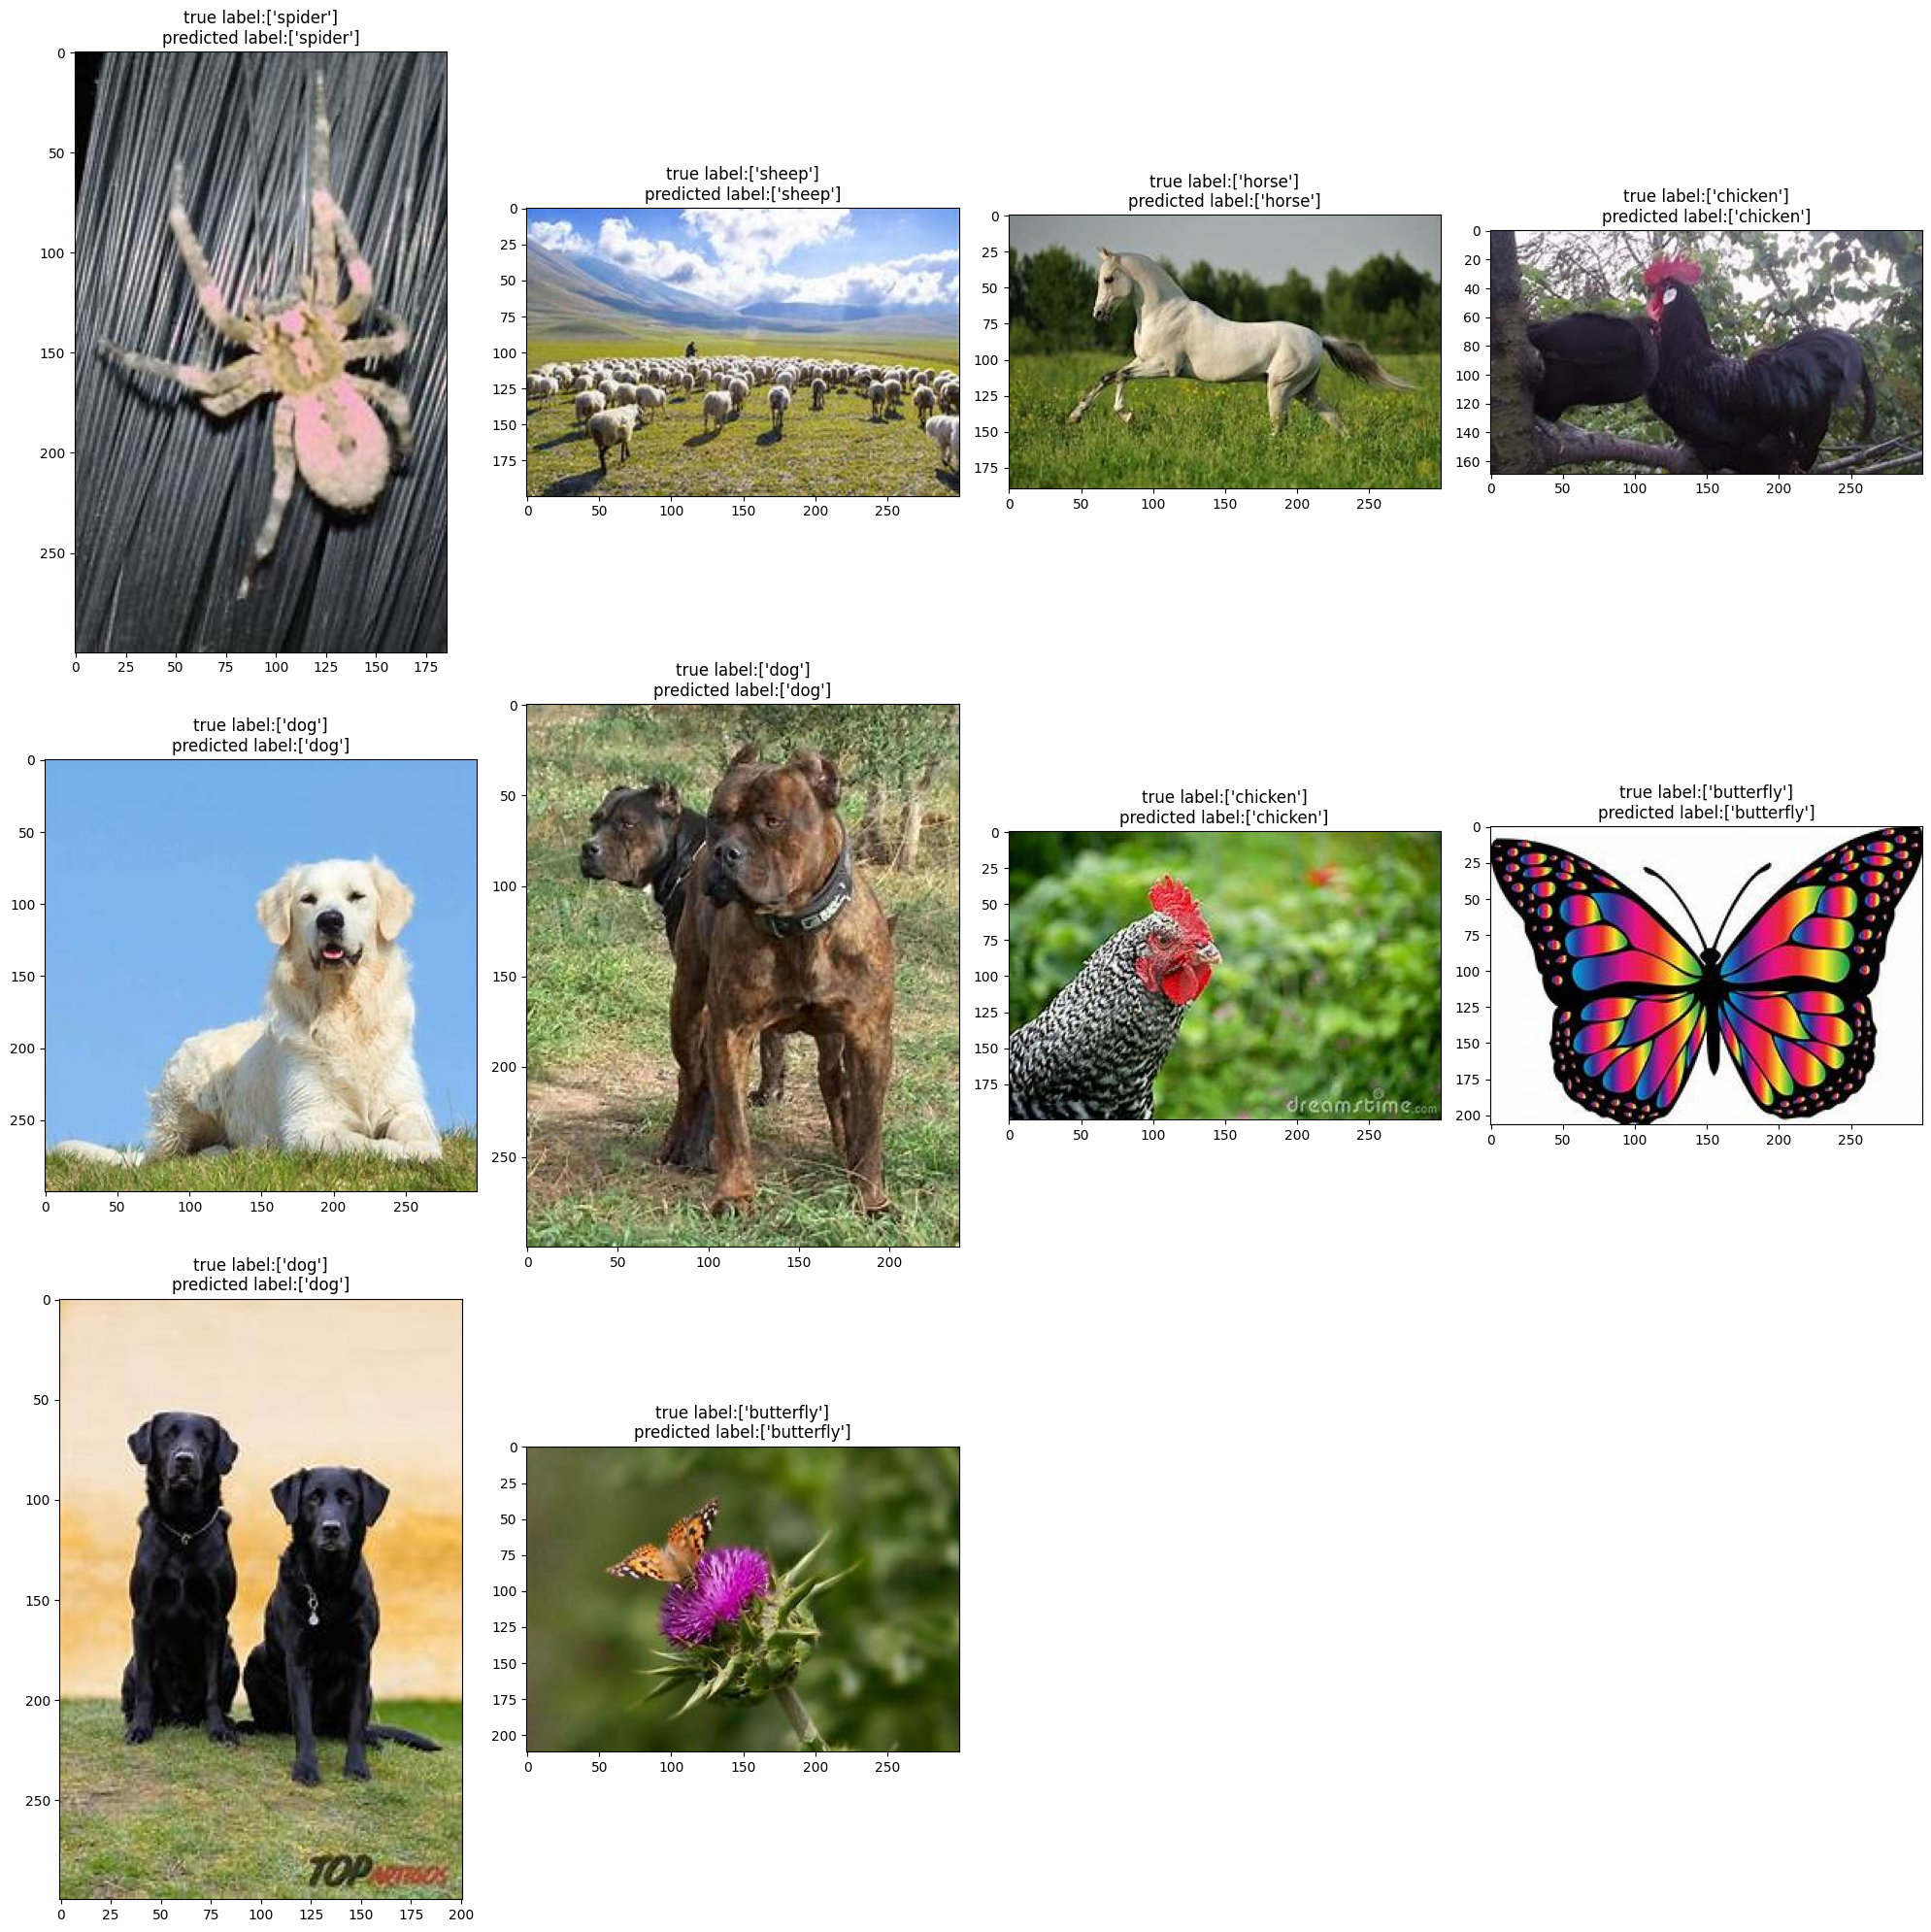

In [53]:
model=resnet_transfer.load_from_checkpoint("model.ckpt")
model.eval()
fig=plt.figure(figsize=(20,20))

for i in range (10):
  test_image=Image.open(test_df.iloc[i,0])#test_df.iloc[0,0]
  test_label=le.inverse_transform(torch.tensor([test_df.iloc[i,1]]))
  z=transforms(test_image)
  z=z.unsqueeze(0)
  y=model(z)
  y=torch.argmax(y,1)
  y=le.inverse_transform(y)
  plt.subplot(3,4,i+1)
  plt.imshow(test_image)
  plt.title(f"true label:{test_label}\npredicted label:{y}")
  plt.axis("on")

plt.tight_layout() # Add this line to adjust the layout
plt.show()
